In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
home_dir = Path('/content/drive/MyDrive/266 Final Project')
em_df_path =  home_dir / 'em_df.csv'
ex_df_path = home_dir / 'ex_df.csv'
in_df_path = home_dir / 'in_df.csv'

em_df = pd.read_csv(em_df_path)
ex_df = pd.read_csv(ex_df_path)
in_df = pd.read_csv(in_df_path)

In [6]:
print("em_df label distribution\n",em_df['level'].value_counts())
print("\nex_df label distribution\n",ex_df['level'].value_counts())
print("\nin_df label distribution\n",in_df['level'].value_counts())


em_df label distribution
 0    2037
1     895
2     152
Name: level, dtype: int64

ex_df label distribution
 0    2604
2     376
1     104
Name: level, dtype: int64

in_df label distribution
 0    1626
2    1344
1     114
Name: level, dtype: int64


In [ ]:
em_df.iloc[7]

sp_id                                                          7oi3es
rp_id                                                         ds9oti2
seeker_post         I called in sick to work today. For the first ...
response_post       Is that really so bad? Maybe it was the smart ...
level                                                               1
rationales                                 Hope you feel better soon|
seeker_length                                                     249
response_length                                                   196
seeker_words                                                       52
response_words                                                     36
rationale_start                                                 [170]
rationale_length                                                 [25]
rationale_words                                                   [5]
rationale_end                                                   [195]
Name: 7, dtype: obje

In [ ]:
in_df.iloc[7]

sp_id                                                          7oi3es
rp_id                                                         ds9oti2
seeker_post         I called in sick to work today. For the first ...
response_post       Is that really so bad? Maybe it was the smart ...
level                                                               0
rationales                                                        NaN
seeker_length                                                     249
response_length                                                   196
seeker_words                                                       52
response_words                                                     36
rationale_start                                                   NaN
rationale_length                                                  NaN
rationale_words                                                   NaN
rationale_end                                                     NaN
Name: 7, dtype: obje

In [ ]:
ex_df.iloc[7]

sp_id                                                          7oi3es
rp_id                                                         ds9oti2
seeker_post         I called in sick to work today. For the first ...
response_post       Is that really so bad? Maybe it was the smart ...
level                                                               1
rationales                                    Is that really so bad?|
seeker_length                                                     249
response_length                                                   196
seeker_words                                                       52
response_words                                                     36
rationale_start                                                   [0]
rationale_length                                                 [22]
rationale_words                                                   [5]
rationale_end                                                    [22]
Name: 7, dtype: obje

## EM level ONLY prediction using BERT embeddings

In [7]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [8]:
X_em = em_df['response_post'].to_list()
y_em = em_df['level'].to_numpy()

X_em_train, X_em_temp, y_em_train, y_em_temp = train_test_split(X_em, y_em, test_size=0.2, random_state=42)
X_em_val, X_em_test, y_em_val, y_em_test = train_test_split(X_em_temp, y_em_temp, test_size=0.5, random_state=42)

print(len(X_em_train))
print(len(X_em_val))
print(len(X_em_test))

2467
308
309


In [9]:
X_em_train[:3]

['You do whatever you need to do.',
 'About 18 months back, I made a post after cutting ties with some of my closest friends, saying, There is only family, and before that I was posting tons of dark poetry and misanthropic musings. Guess what? NOBODY CARED. Which really made me fantasize about killing myself, all the while thinking, IS THIS WHAT YOU GUYS WANT? IS THIS ENOUGH TO GET YOU CONCERNED? HUH? FUCKERS!',
 "I had this exact thought the other day. Like I know that it's stupid, but I keep acting like this. The moment I find myself being remotely positive or happy I steer away from that feeling."]

In [10]:
class_weights_em = compute_class_weight('balanced', classes=np.unique(y_em_train), y=y_em_train)
class_weight_em = dict(enumerate(class_weights_em))
class_weight_em


{0: 0.5051187551187551, 1: 1.1453110492107708, 2: 6.796143250688705}

In [11]:
# tokenize the dataset, truncate at `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
max_length = 100
train_em_encodings = bert_tokenizer(X_em_train, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
val_em_encodings = bert_tokenizer(X_em_val, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_em_encodings = bert_tokenizer(X_em_test, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [12]:
train_em_encodings

{'input_ids': <tf.Tensor: shape=(2467, 100), dtype=int32, numpy=
array([[  101,  1192,  1202, ...,     0,     0,     0],
       [  101,  3517,  1407, ...,  3048, 16972,   102],
       [  101,   146,  1125, ...,     0,     0,     0],
       ...,
       [  101, 14060,   119, ...,     0,     0,     0],
       [  101,  1284,   112, ...,     0,     0,     0],
       [  101, 10560,  1176, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2467, 100), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2467, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [13]:
def create_bert_multiclass_model(bert_model,
                                 num_classes = 3,
                                 hidden_size = 100,
                                 dropout=0.3,
                                 learning_rate=0.0005):


    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                 metrics='accuracy')



    return classification_model

In [14]:
em_classification = create_bert_multiclass_model(bert_model=bert_model)

In [15]:
em_classification_history = em_classification.fit([train_em_encodings.input_ids, train_em_encodings.token_type_ids, train_em_encodings.attention_mask],
                                                  y_em_train,
                                                  validation_data=([val_em_encodings.input_ids, val_em_encodings.token_type_ids, val_em_encodings.attention_mask],
                                                  y_em_val),
                                                  batch_size=8,
                                                  epochs=3,
                                                  class_weight=class_weight_em
                                                  )

Epoch 1/3


309/309 [==============================] - 160s 291ms/step - loss: 1.2179 - accuracy: 0.3125 - val_loss: 1.1000 - val_accuracy: 0.2662
Epoch 2/3
309/309 [==============================] - 85s 276ms/step - loss: 1.1039 - accuracy: 0.3591 - val_loss: 1.0333 - val_accuracy: 0.6883
Epoch 3/3
309/309 [==============================] - 70s 227ms/step - loss: 1.1070 - accuracy: 0.2359 - val_loss: 1.0094 - val_accuracy: 0.6883


In [16]:
#run predict for the first three elements in the test data set
predictions_em = em_classification.predict([test_em_encodings.input_ids, test_em_encodings.token_type_ids, test_em_encodings.attention_mask])
predictions_em = tf.argmax(predictions_em, axis=-1)
predictions_em

10/10 [==============================] - 14s 213ms/step


<tf.Tensor: shape=(309,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

### Use T5 to paraphrase

In [17]:
import random

In [1]:
!pip install -q sentencepiece

In [2]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

In [25]:
def paraphrase_text(text, max_length=512):
    input_text = "paraphrase: " + text + " </s>"

    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=max_length, truncation=True)
    paraphrased_ids = model.generate(input_ids, max_length=max_length, num_return_sequences=3, num_beams=5, temperature=1.5)
    paraphrased_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in paraphrased_ids]

    return paraphrased_texts

In [19]:
level_2_em_responses = em_df[em_df['level']==2]['response_post'].to_list()
print(len(level_2_em_responses))
level_2_em_responses[:3]

152


['sorry to hear that, but been in a similar situation after taking some time off of school. My best advice is to take the minimum amount of classes possible so you get too overwhelmed. For me essential to plan my assignments in advance, so that I can just do things one by one and not let it all get piled up cuz then I wanna die. Also, if you need a break, take one. School will always be there but good to take care of yourself too :)',
 "I'm sorry, my friend. I lost my mum too, two years ago. I feel your pain but it'll get better for you, I promise.",
 "omg lol I 100% blame my parents. After taking an AP Psychology course at my school, it kind of shifted my own perspective on my depression. I know I can't claim to be an expert after reading just one textbook, but even an idiot can realize that your behavior and who you are is just totally as a result of your parents. The genetic aspects aren't their fault of course, but they are perfect human specimens, so you can imagine what 17 years 

In [26]:
paraphrased_em2 = [paraphrase_text(text) for text in level_2_em_responses]
print(len(paraphrased_em2))
paraphrased_em2[:10]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


152


[['False',
  "Falafel: I've been in a similar situation after taking some time off of school. Falafel: if you need a break, take one. School will always be there but good to take care of yourself too.",
  "Falco: I've been in similar situation after taking some time off of school. Falco: if you need a break, take one. School will always be there but good to take care of yourself too."],
 ['True',
  'False',
  'FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE FalsE'],
 ["roland martin: my parents are perfect human specimens, so I can't keep blaming them for everything. he says it's incredible that they can find the gall to abdicate themselves of all guilt and responsibility. martin: i'd better just get on my hands and knees and obey their every whim.",
  "roland martin: my parents are perfect human specimens, so I can't keep bla

In [ ]:
# level_1_em_responses = em_df[em_df['level']==1]['response_post'].to_list()
# sample_per_class = len()
# selected_elements = random.sample(level_1_em_responses, sample_per_class)


## IN level ONLY prediction with seeker+response

In [12]:
#combine seeker and resopnse in the new X_combined
X_in_seeker = in_df['seeker_post'].to_list()
X_in_response = in_df['response_post'].to_list()
y_in = in_df['level'].to_numpy()
X_in_combined = list(zip(X_in_seeker,X_in_response))
X_in_combined[0]

("Help. Help me. I dunno what I'm doing anymore",
 "That's pretty vague, do you not know what you're doing in regards to a specific section of your life? Like school or work?")

In [13]:
X_in_combined_train, X_in_combined_temp, y_in_train, y_in_temp = train_test_split(X_in_combined, y_in, test_size=0.2, random_state=42)
X_in_combined_val, X_in_combined_test, y_in_val, y_in_test = train_test_split(X_in_combined_temp, y_in_temp, test_size=0.5, random_state=42)

print(len(X_in_combined_train))
print(len(X_in_combined_val))
print(len(X_in_combined_test))

2467
308
309


In [25]:
X_in_combined_train[:2]

[("Sleeping in the bathtub. Moved my pillow and cover into the tub tonight. Because it's just one of those days. I'm so depressed that I want to die. And sleeping in a freaking tub somehow makes me feel better.",
  'You do whatever you need to do.'),
 ("I broke down and made a Facebook status recently in an effort to say I'd be going on a hiatus to clear my mind and get off drugs, I must have got 40 messages of support.. I wonder how many of those people will actually follow up or just did it for the sake of doing it rather than caring about me.",
  'About 18 months back, I made a post after cutting ties with some of my closest friends, saying, There is only family, and before that I was posting tons of dark poetry and misanthropic musings.  Guess what? NOBODY CARED.  Which really made me fantasize about killing myself, all the while thinking, IS THIS WHAT YOU GUYS WANT? IS THIS ENOUGH TO GET YOU CONCERNED? HUH? FUCKERS!')]

In [37]:
#insert [SEP] between seeker and response
def tokenize_pairs(text_pairs, max_length):
  encodings = bert_tokenizer([pair[0] + " [SEP] " + pair[1] for pair in text_pairs],
  truncation=True,
  padding=True,
  max_length=max_length,
  return_tensors='tf'
  )
  return encodings


In [38]:
max_length = 200
train_in_encodings = tokenize_pairs(X_in_combined_train, max_length)
val_in_encodings = tokenize_pairs(X_in_combined_val, max_length)
test_in_encodings = tokenize_pairs(X_in_combined_test, max_length)

In [39]:
train_in_encodings

{'input_ids': <tf.Tensor: shape=(2467, 200), dtype=int32, numpy=
array([[  101, 21751,  1107, ...,     0,     0,     0],
       [  101,   146,  2795, ...,     0,     0,     0],
       [  101,   146,  1631, ...,     0,     0,     0],
       ...,
       [  101,  1422,  1404, ...,     0,     0,     0],
       [  101,  1398,  1115, ...,     0,     0,     0],
       [  101,   178,  3983, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2467, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2467, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [42]:
def create_bert_multiclass_model(bert_model,
                                 num_classes = 3,
                                 hidden_size = 100,
                                 dropout=0.3,
                                 learning_rate=0.0005):


    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                 metrics='accuracy')



    return classification_model

In [44]:
class_weights_in = compute_class_weight('balanced', classes=np.unique(y_in_train), y=y_in_train)
class_weight_in = dict(enumerate(class_weights_in))
class_weight_in

{0: 0.627735368956743, 1: 9.137037037037038, 2: 0.7706966572945955}

In [43]:
in_classification = create_bert_multiclass_model(bert_model=bert_model)

In [45]:
in_classification_history = in_classification.fit([train_in_encodings.input_ids, train_in_encodings.token_type_ids, train_in_encodings.attention_mask],
                                                  y_in_train,
                                                  validation_data=([val_in_encodings.input_ids, val_in_encodings.token_type_ids, val_in_encodings.attention_mask],
                                                  y_in_val),
                                                  batch_size=20,
                                                  epochs=1,
                                                  class_weight=class_weight_in
                                                  )

124/124 [==============================] - 159s 911ms/step - loss: 1.2857 - accuracy: 0.3064 - val_loss: 1.0837 - val_accuracy: 0.5065


In [47]:
#run predict for the first three elements in the test data set
predictions_in = in_classification.predict([test_in_encodings.input_ids, test_in_encodings.token_type_ids, test_in_encodings.attention_mask])
predictions_in = tf.argmax(predictions_in, axis=-1)
predictions_in

10/10 [==============================] - 7s 403ms/step


<tf.Tensor: shape=(309,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

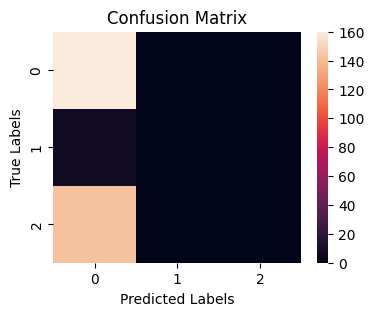

In [50]:
cm_in = confusion_matrix(y_in_test, predictions_in)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_in)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## EM,EX and IN prediction with same model

In [ ]:
in_df_sorted = in_df.sort_values(by=['sp_id', 'rp_id']).reset_index(drop=True)
em_df_sorted = em_df.sort_values(by=['sp_id', 'rp_id']).reset_index(drop=True)
ex_df_sorted = ex_df.sort_values(by=['sp_id', 'rp_id']).reset_index(drop=True)

print(in_df_sorted.iloc[:,0].equals(ex_df_sorted.iloc[:,0]) and in_df_sorted.iloc[:,0].equals(em_df_sorted.iloc[:,0])
)
print(in_df_sorted.iloc[:,1].equals(ex_df_sorted.iloc[:,1]) and in_df_sorted.iloc[:,1].equals(em_df_sorted.iloc[:,1])
)

print(in_df_sorted.iloc[:,2].equals(ex_df_sorted.iloc[:,2]) and in_df_sorted.iloc[:,2].equals(em_df_sorted.iloc[:,2]))

print(in_df_sorted.iloc[:,3].equals(ex_df_sorted.iloc[:,3]) and in_df_sorted.iloc[:,3].equals(em_df_sorted.iloc[:,3]))

True
True
False
False


In [ ]:
column_comparison = in_df_sorted.iloc[:, 2] == em_df_sorted.iloc[:, 2]
different_rows = column_comparison[column_comparison == False].index.tolist()
different_rows

for i in range(0,5):
  print(in_df_sorted.iloc[different_rows[i], 2])
  print(em_df_sorted.iloc[different_rows[i], 2])


So what hobbies do you have?. Looking for new things to do that take my mind off unpleasent stuff  Been trying to branch out and just do something
So what hobbies do you have?. Looking for new things to do that take my mind off unpleasent stuff Been trying to branch out and just do something
If she marries him, I will die of jealousy.. I know it's foolish, but I can't stop this feeling. I should have told her so many years ago, when they had just met.  But I thought I was taking the higher ground by keeping silent and backing off. All I did was hurt myself.
If she marries him, I will die of jealousy.. I know it's foolish, but I can't stop this feeling. I should have told her so many years ago, when they had just met. But I thought I was taking the higher ground by keeping silent and backing off. All I did was hurt myself.
I'm crashing hard right now. I'm crashing really hard right now. This is the worst I've been in a few months, and I just feel like shit is never gonna get better. Whe

In [ ]:
column_comparison = in_df_sorted.iloc[:, 3] == em_df_sorted.iloc[:, 3]
different_rows = column_comparison[column_comparison == False].index.tolist()
different_rows

for i in range(0,5):
  print(in_df_sorted.iloc[different_rows[i], 2])
  print(em_df_sorted.iloc[different_rows[i], 2])


When (if you remember at all) was the last time you were happy?. For me, it's been 4 years. I'm anxious, and timid, and I hate my life but I remember those times and try to have hope... Will I ever be happy again? I'm only 16 but damn that would be a fucking shitty life.
When (if you remember at all) was the last time you were happy?. For me, it's been 4 years. I'm anxious, and timid, and I hate my life but I remember those times and try to have hope... Will I ever be happy again? I'm only 16 but damn that would be a fucking shitty life.
For the past 6 months, I have had this persistent head pressure (not a migraine or headache). It's like my brain is expanding but has no room. It's incredibly distracting.. I've tried taking everything from excedrin to ibuprofen and neither do anything. I also find it incredibly difficult to concentrate and remember anymore, constantly needed things repeated over and over slowly. Aside from the insomnia, I feel like the head pressure, concentration and

taking only the seeker_post and response_post column from em_df, assuming the differences are only due to typos

In [ ]:
# use the same data from X, but create 3 sets of labels for y
# split indices
sample_size = len(em_df)

train_indices, temp_indices = train_test_split(range(sample_size), test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

print(f"{len(train_indices)} samples in train")
print(f"{len(val_indices)} samples in val")
print(f"{len(test_indices)} samples in test")


#create X
X_train = em_df.iloc[train_indices]['response_post'].to_list()
X_val = em_df.iloc[val_indices]['response_post'].to_list()
X_test = em_df.iloc[test_indices]['response_post'].to_list()

#create y
def split_df(df, train_idx, val_idx, test_idx):
    y_train = df.iloc[train_idx]['level'].to_numpy()
    y_val = df.iloc[val_idx]['level'].to_numpy()
    y_test = df.iloc[test_idx]['level'].to_numpy()
    return y_train, y_val, y_test

y_in_train, y_in_val, y_in_test = split_df(in_df_sorted, train_indices, val_indices, test_indices)
y_em_train, y_em_val, y_em_test = split_df(em_df_sorted, train_indices, val_indices, test_indices)
y_ex_train, y_ex_val, y_ex_test = split_df(ex_df_sorted, train_indices, val_indices, test_indices)

print(len(y_em_train)==len(y_in_train)==len(y_ex_train))
print(len(y_em_val)==len(y_in_val)==len(y_ex_val))
print(len(y_em_test)==len(y_in_test)==len(y_ex_test))


2467 samples in train
308 samples in val
309 samples in test
True
True
True


In [ ]:
# tokenize the dataset, truncate at `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
max_length = 100
train_encodings = bert_tokenizer(X_train, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
val_encodings = bert_tokenizer(X_val, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(X_test, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
class_weights_em = compute_class_weight('balanced', classes=np.unique(y_em_train), y=y_em_train)
class_weight_dict_em = dict(enumerate(class_weights_em))

class_weights_ex = compute_class_weight('balanced', classes=np.unique(y_ex_train), y=y_ex_train)
class_weight_dict_ex = dict(enumerate(class_weights_ex))

class_weights_in = compute_class_weight('balanced', classes=np.unique(y_in_train), y=y_in_train)
class_weight_dict_in = dict(enumerate(class_weights_in))

In [ ]:
def create_bert_3prediction_model(bert_model,
                                 num_classes = 3,
                                 hidden_size = 100,
                                 dropout=0.3,
                                 learning_rate=0.0005):


    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification_em = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_em')(hidden)
    classification_ex = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_ex')(hidden)
    classification_in = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_in')(hidden)


    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask],
                                          outputs=[classification_em, classification_ex, classification_in])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=[tf.keras.losses.SparseCategoricalCrossentropy(),
                                       tf.keras.losses.SparseCategoricalCrossentropy(),
                                       tf.keras.losses.SparseCategoricalCrossentropy()],
                                 metrics='accuracy')


    return classification_model

In [ ]:
bert_3prediction_model = create_bert_3prediction_model(bert_model=bert_model)

In [ ]:
bert_3prediction_model_history = bert_3prediction_model.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
    [y_em_train, y_ex_train, y_in_train],
    validation_data=(
        [val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask],
        [y_em_val, y_ex_val, y_in_val]
    ),
    batch_size=20,
    epochs=1
    #class_weight=[class_weight_dict_em, class_weight_dict_ex, class_weight_dict_in]
)


124/124 [==============================] - 3396s 27s/step - loss: 2.2349 - classification_em_loss: 0.8239 - classification_ex_loss: 0.5565 - classification_in_loss: 0.8545 - classification_em_accuracy: 0.6542 - classification_ex_accuracy: 0.8411 - classification_in_accuracy: 0.4990 - val_loss: 2.1383 - val_classification_em_loss: 0.8015 - val_classification_ex_loss: 0.5521 - val_classification_in_loss: 0.7847 - val_classification_em_accuracy: 0.6429 - val_classification_ex_accuracy: 0.8344 - val_classification_in_accuracy: 0.5162


## Rationale extraction

In [ ]:
# first need to adjust the indices to map word index to token index per BERT tokenization rules

def adjust_indices_for_tokenization(texts, start_char_indices, end_char_indices):
    adjusted_start_indices = []
    adjusted_end_indices = []

    for text, start_char_idx, end_char_idx in zip(texts, start_char_indices, end_char_indices):
        encoding = bert_tokenizer.encode_plus(
            text,
            return_offsets_mapping=True,
            max_length=max_length,
            truncation=True
        )
        offset_mapping = encoding['offset_mapping']

        start_token_idx = None
        end_token_idx = None

        for idx, (start, end) in enumerate(offset_mapping):
            if start <= start_char_idx < end:
                start_token_idx = idx
            if start < end_char_idx <= end:
                end_token_idx = idx

        adjusted_start_indices.append(start_token_idx)
        adjusted_end_indices.append(end_token_idx)

    return adjusted_start_indices, adjusted_end_indices